## Set-up


In [24]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from helper import *
import math

import cv2
from PIL import Image
from scipy.ndimage import binary_dilation, binary_erosion

from pymatting import cutout

import sys
sys.path.append('/Users/susanto/Documents/Proyek/best-remove-background/latihan-remove-background/PytorchSuccessExample/algorithm/DIS/IS-Net')
from DIS import getDISMask
from transparent_background import Remover

In [25]:
def random_color():
    # Generate random values for red, green, and blue
    r, g, b = [random.randint(0, 255) for i in range(3)]
    # Create a numpy array with the random RGB values and fixed alpha value of 255
    color = np.array([r, g, b, 255], dtype=np.uint8)
    return color

# print(color)  # prints something like [112  43 194 255]


In [26]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


## Example image


In [27]:
image_path = 'images/gawang.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


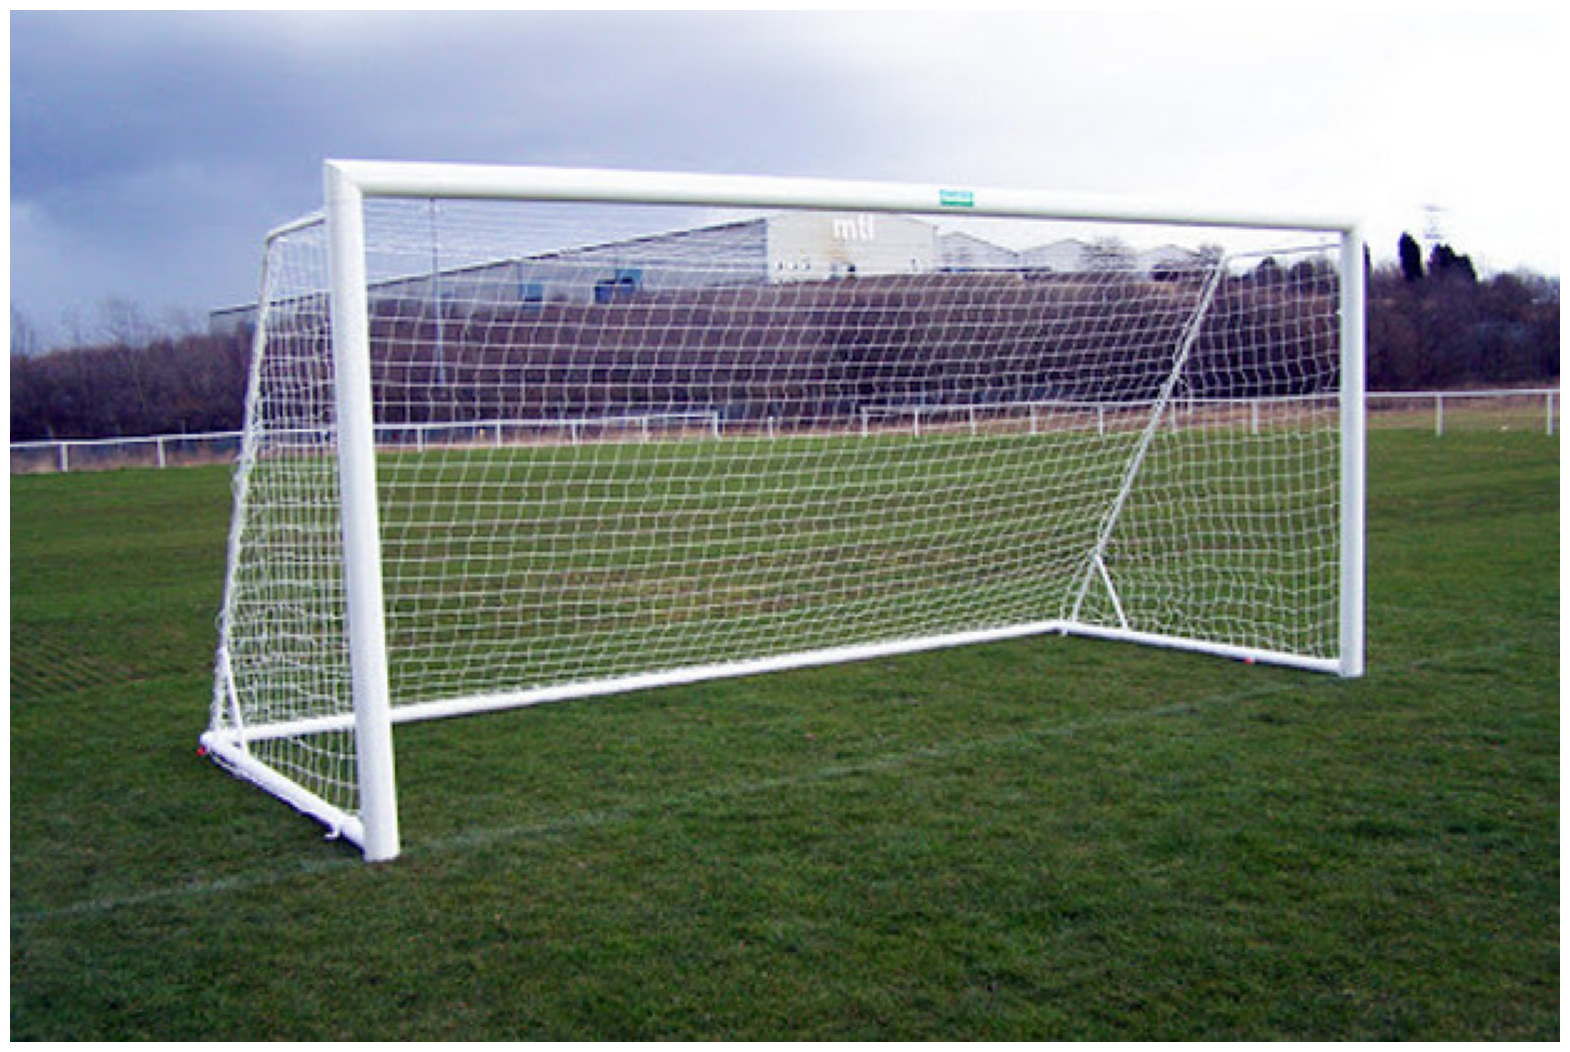

In [28]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()


## Automatic mask generation


To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.


In [29]:
import sys
# sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/Users/susanto/Documents/Proyek/best-remove-background/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

# print(mask_generator)


To generate masks, just run `generate` on an image.


In [30]:
masks = mask_generator.generate(image)


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- `segmentation` : the mask
- `area` : the area of the mask in pixels
- `bbox` : the boundary box of the mask in XYWH format
- `predicted_iou` : the model's own prediction for the quality of the mask
- `point_coords` : the sampled input point that generated this mask
- `stability_score` : an additional measure of mask quality
- `crop_box` : the crop of the image used to generate this mask in XYWH format


In [31]:
print(len(masks))
print(masks[0].keys())


27
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [32]:
# RGB numpy array to RGBA numpy array
rgba_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
rgba_image[:, :, :3] = image
rgba_image[:, :, 3] = 255


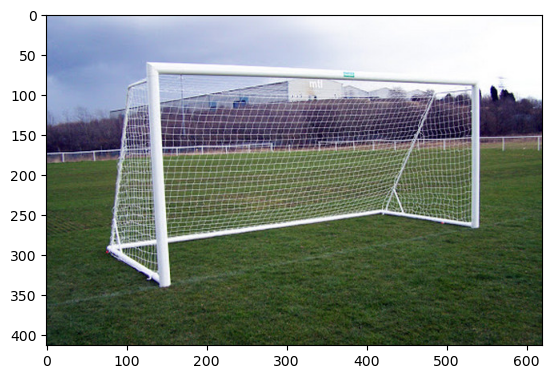

In [33]:
plt.imshow(rgba_image)


In [34]:
# # Make blank image with same size
# base_img = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)


In [35]:
def get_edge_mask(mask):
    # Dilate the mask to get the boundary pixels
    dilated_mask = binary_dilation(mask)
    # Erode the mask to get the interior pixels
    eroded_mask = binary_erosion(mask)
    # Subtract the eroded mask from the dilated mask to get the boundary pixels
    edge_mask = np.logical_and(dilated_mask, np.logical_not(eroded_mask))
    return edge_mask


In [36]:
print(type(image))

print(rgba_image.shape)


<class 'numpy.ndarray'>
(413, 620, 4)


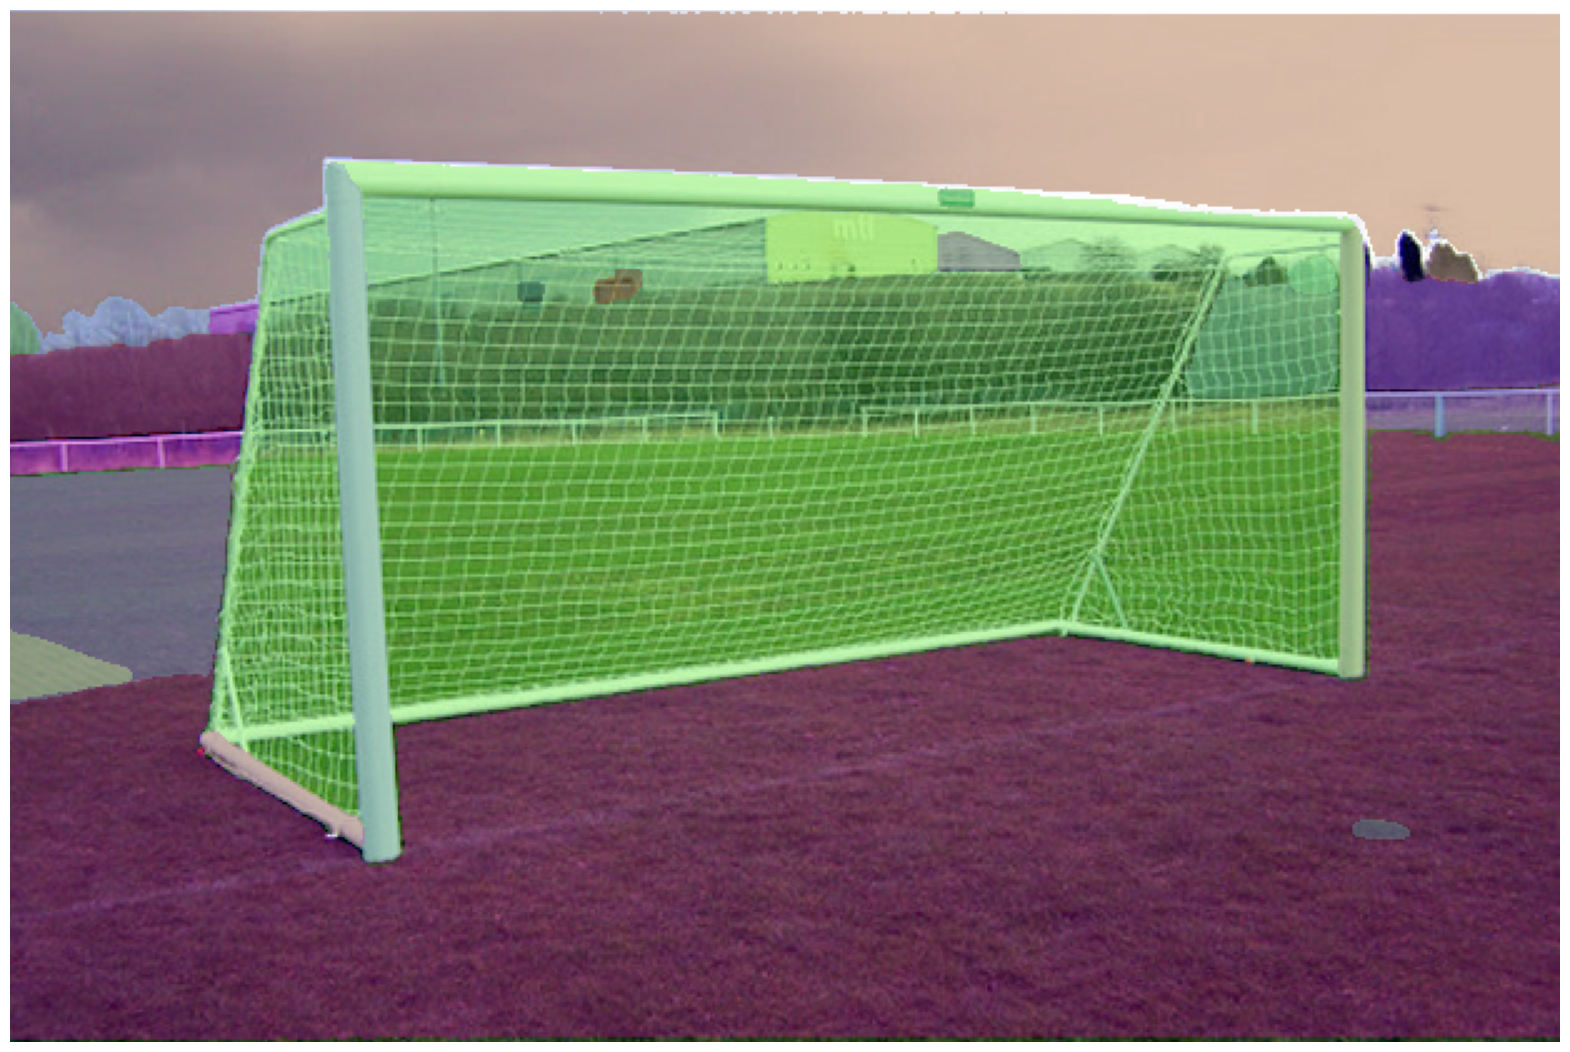

In [37]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()


In [38]:
len(masks)

27

In [39]:
x = masks[0]["segmentation"]

mask = x.astype(np.uint8) * 255

# plt.imshow(mask)
print(mask)

[[  0   0   0 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [49]:
PIL_image = Image.fromarray(rgba_image)
PIL_image.save('output/all.png')

PIL_image = PIL_image.convert("RGB")
PIL_image.save('output/all.jpg')

mask_dis = getDISMask('output/all.jpg', device="cpu",
                      model_path="/Users/susanto/Documents/Proyek/best-remove-background/models/DIS_isnet.pth")
# print(mask_dis)
# plt.imshow(mask_dis)
m = rgba_image.copy()
m[:, :, 3] = mask_dis

PIL_image = Image.fromarray(m)
PIL_image.save('output/all_dis.png')


In [41]:
# Load model
# remover = Remover() # default setting
remover = Remover(fast=True, jit=True, device='cpu', ckpt='/Users/susanto/Documents/Proyek/best-remove-background/models/InSPyReNet_ SwinB_Large.pth') # custom setting


B /Users/susanto/Documents/Proyek/best-remove-background/models/InSPyReNet_ SwinB_Large.pth
Settings -> Mode=fast, Device=cpu, Torchscript=enabled


In [81]:
PIL_image = Image.open('output/all.jpg')
out = remover.process(PIL_image)  # default setting - transparent background

Image.fromarray(out).save('output/all_InSPyReNet.png') # save result

In [83]:
binary_mask = np.zeros((out.shape[0], out.shape[1]), dtype=np.uint8)

In [91]:
# Create a mask of visible pixels
mask = out[..., 3] > 20  # Check alpha channel for non-zero values

# Apply the mask to the image
masked_image = out[..., :3]  # Keep only RGB channels
masked_image = np.where(mask[..., None], masked_image, 0)  # Set transparent pixels to 0


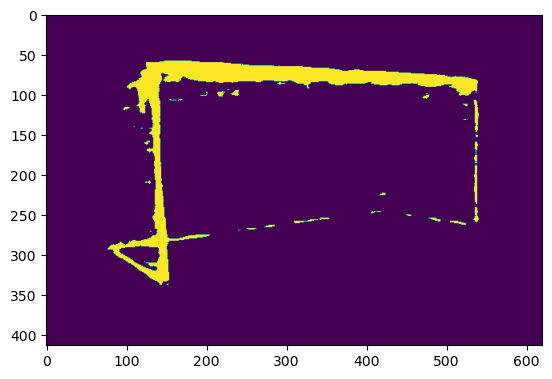

In [115]:
u = out[..., 3] > 200

plt.imshow(u)

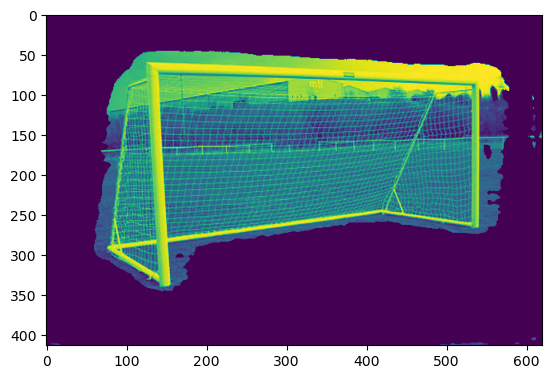

In [92]:
# Convert RGBA image to grayscale
gray_image = cv2.cvtColor(masked_image.astype(np.uint8), cv2.COLOR_RGBA2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

plt.imshow(gray_image)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


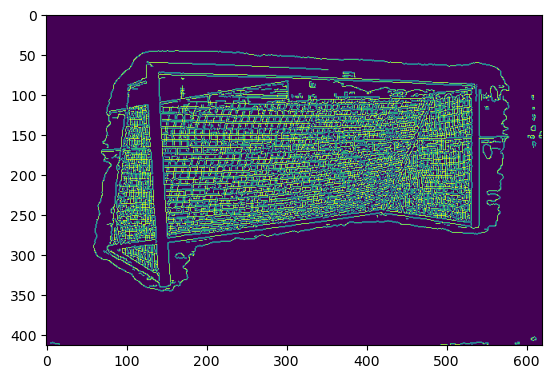

In [93]:
threshold = 0  # Set the threshold value
binary_mask = edges > threshold

print(binary_mask)
plt.imshow(binary_mask)

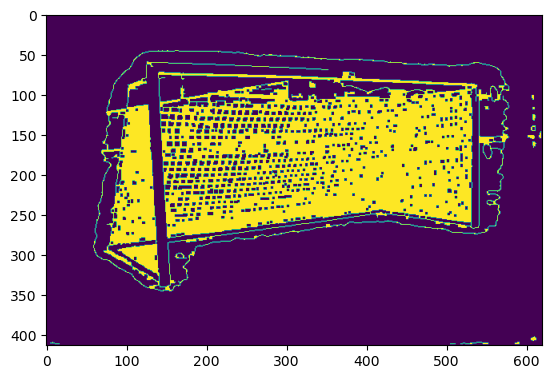

In [102]:
# Perform dilation
dilated_mask = binary_dilation(binary_mask, structure=np.ones((3, 3)))

# Perform erosion
eroded_mask = binary_erosion(dilated_mask, structure=np.ones((3, 3)))


# plt.imshow(binary_mask)
plt.imshow(eroded_mask)

# Create the trimap
# trimap = np.zeros_like(binary_mask)
# trimap[binary_mask] = 255  # Set foreground
# trimap[dilated_mask] = 127  # Set transition
# trimap[eroded_mask] = 0  # Set background

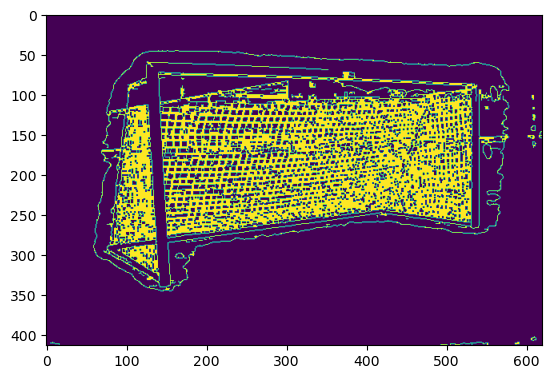

In [103]:
structuring_element_size=2

# Perform binary dilation to get the foreground region
foreground = binary_dilation(binary_mask, structure=np.ones((structuring_element_size, structuring_element_size)))

# Perform binary erosion to get the background region
background = binary_erosion(foreground, structure=np.ones((structuring_element_size, structuring_element_size)))

plt.imshow(background)


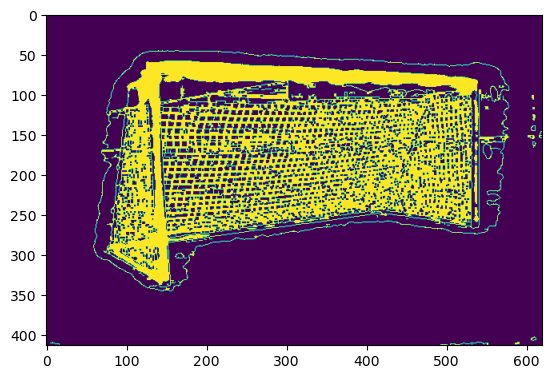

In [116]:
combined_mask = np.logical_or(background, u)
plt.imshow(combined_mask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


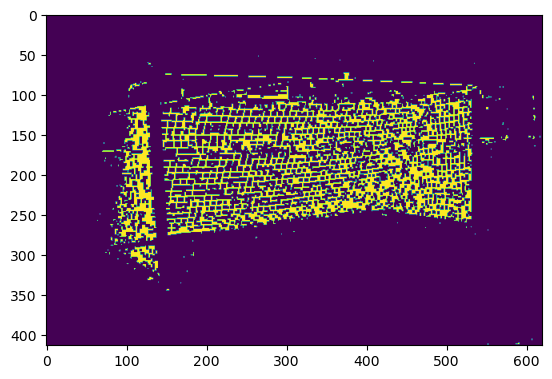

In [108]:
# Perform binary erosion to get the background region
a = binary_erosion(background, structure=np.ones((structuring_element_size, structuring_element_size)))
plt.imshow(a)

print(a)


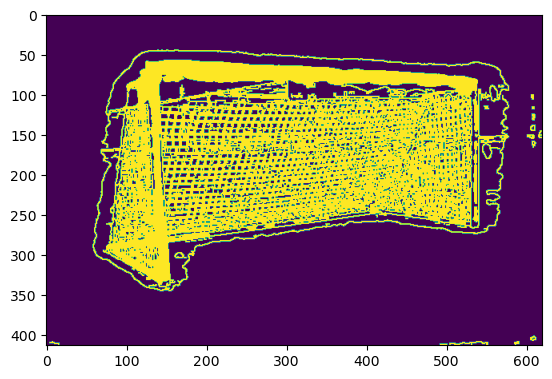

In [118]:
structuring_element_size=2

# Perform binary dilation to get the foreground region
foreground2 = binary_dilation(combined_mask, structure=np.ones((structuring_element_size, structuring_element_size)))

plt.imshow(foreground2)


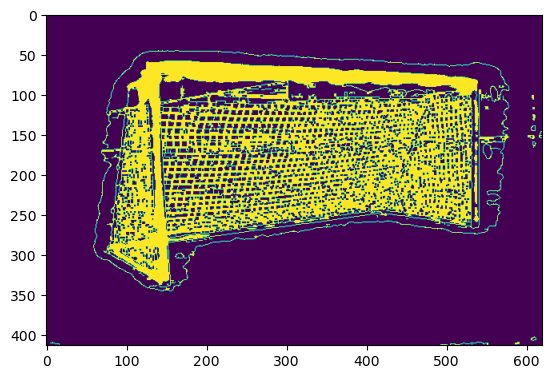

In [119]:
plt.imshow(combined_mask)

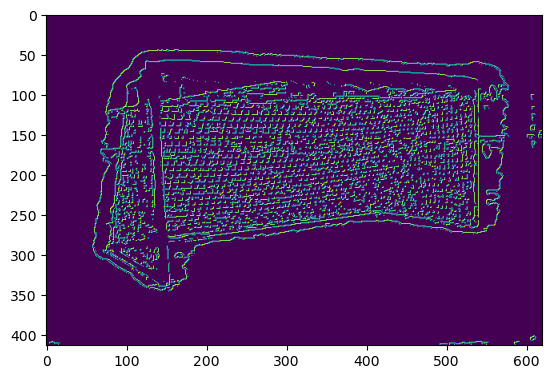

In [122]:
transition_mask = np.logical_and(foreground2, np.logical_not(combined_mask))

plt.imshow(transition_mask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


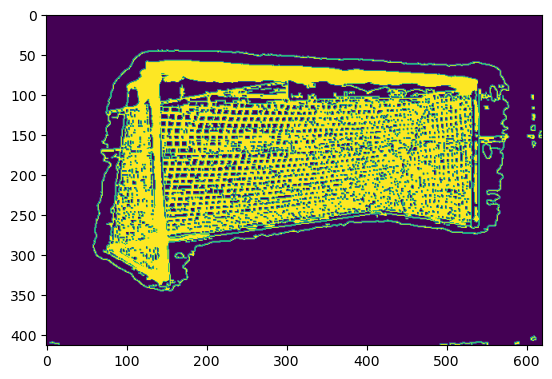

In [125]:
# Create the trimap
trimap = np.where(combined_mask, 255, np.where(transition_mask, 127, 0))

trimap= trimap.astype(np.uint8)

print(trimap)

koko = Image.fromarray(trimap)

koko.save("output/all_trimap.jpg")

plt.imshow(trimap)


In [126]:
image = load_image("output/all.jpg", "RGB")
trimap = load_image("output/all_trimap.jpg", "GRAY")

alpha = estimate_alpha_lbdm(
    image,
    trimap,
    laplacian_kwargs={"epsilon": 1e-6},
    cg_kwargs={"maxiter": 2000})

alpha = (alpha * 255)
cr = rgba_image.copy()

cr[:, :, 3] = alpha
# print(alpha.shape)
# print(alpha)

PIL_image = Image.fromarray(cr)
PIL_image.save("output/all_alpha.png")


In [43]:
def crop_image_with_bounding_box(img, bounding_box):
    x1, y1, x2, y2 = bounding_box
    cropped_image = img[y1:y2, x1:x2, :]
    return cropped_image

In [44]:
from pymatting import *


In [47]:
# Convert new masks
index = 0

arr = []

for a in masks:
    x = a["segmentation"]

    # mask = x.astype(np.uint8) * 255

    # # Dilate the mask
    # kernel = np.ones((5, 5), np.uint8)
    # dilated_mask = cv2.dilate(mask, kernel, iterations=4)

    # # Erode the mask
    # eroded_mask = cv2.erode(mask, kernel, iterations=2)

    m = rgba_image.copy()
    m[x == False] = [0, 0, 0, 0]
    PIL_image = Image.fromarray(m)
    PIL_image.save('output/'+str(index)+"_origin.png")

    [PIL_image, bounding] = cropUnusedBlankPixel(PIL_image)

    # print(bounding)

    croped = crop_image_with_bounding_box(rgba_image.copy(), bounding)

    PNG_CROPED_PATH = "output/"+str(index)+"_origin_cropped.png"

    JPG_PATH = "output/"+str(index)+"_origin.jpg"
    PIL_image = Image.fromarray(croped)

    PIL_image.save(PNG_CROPED_PATH)

    PIL_image = PIL_image.convert("RGB")
    PIL_image.save(JPG_PATH)

    mask_dis = getDISMask(JPG_PATH, device="cpu")
    # print(mask_dis)
    # plt.imshow(mask_dis)
    m = croped.copy()
    m[:, :, 3] = mask_dis
    PIL_image = Image.fromarray(m)
    PIL_image.save('output/'+str(index)+"_dis.png")


    PIL_image = Image.open(JPG_PATH)
    out = remover.process(PIL_image)
    Image.fromarray(out).save('output/'+str(index)+"_InSpy.png") # save result

    #  # Apply alpha matting
    # alpha = out[:, :, 3]
    # trimap = np.where(alpha == 0, 0, np.where(
    #     alpha > 150, 255, 127)).astype(np.uint8)

    # print(trimap)
    # print(trimap.shape)

    binary_mask = np.zeros((out.shape[0], out.shape[1]), dtype=np.uint8)

    binary_mask[out[:,:,3]==0]=False
    binary_mask[out[:,:,3]!=0]=True


    # Perform dilation
    dilated_mask = binary_dilation(binary_mask, structure=np.ones((3, 3)))

    # Perform erosion
    eroded_mask = binary_erosion(binary_mask, structure=np.ones((3, 3)))

    # Create the trimap
    trimap = np.zeros_like(binary_mask)
    trimap[binary_mask] = 255  # Set foreground
    trimap[dilated_mask] = 127  # Set transition
    trimap[eroded_mask] = 0 # Set background

    TRIMAP_PATH = "output/"+str(index)+"_trimap.png"

    PIL_image = Image.fromarray(trimap)
    PIL_image.save(TRIMAP_PATH)

    image = load_image(PNG_CROPED_PATH, "RGB")
    trimap = load_image(TRIMAP_PATH, "GRAY")

    alpha = estimate_alpha_lbdm(
        image,
        trimap,
        laplacian_kwargs={"epsilon": 1e-6},
        cg_kwargs={"maxiter":2000})

    alpha = (alpha * 255)
    cr = croped.copy()

    cr[:, :, 3] = alpha
    # print(alpha.shape)
    # print(alpha)

    PIL_image = Image.fromarray(cr)
    PIL_image.save('output/'+str(index)+"_alpha.png")

    # cv2.imwrite('output/'+str(index)+"_alpha.png",
    #             (alpha * 255).astype(np.uint8))

    # Save the result
    # cv2.imwrite('output/'+str(index)+"_alpha.png")

    index += 1


ValueError: Trimap did not contain foreground values (values >= 0.900000)